In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import stan
import nest_asyncio
import arviz as az
from matplotlib.backends.backend_pdf import PdfPages

nest_asyncio.apply()
plt.ion()

DATA_DIR = "./Data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv"

df = pd.read_csv(DATA_DIR) 

df = df.iloc[:, :17]  # Drop all the flag
df_usa = df[df['Jurisdiction of Occurrence'] == 'United States']
df = df[df['Jurisdiction of Occurrence'] != 'United States']
# Sep: Soc nhiem khuan
# Malignant: Khoi u ac tinh
# Diabete: Tieu duong
# Alzheimer: Mat tri nho
# Influenze: Cum - Viem phoi
# Chronic: Nhiem trung duong ho hap duoi man tinh
# Other: nhung benh duong ho hap khac
# Nephristic: Viem than, than hu -> co qua nhieu protein trong nuoc tieu, benh than ma ko co viem nhiem
# Symtoms: Ket qua bat thuong nhung chua dc define
# Diseases of heart: tim co vn de
# Cerebrovascular: Mach mau toi tim, tim len nao
# Visualization
sns.set_theme()


# for x in df.columns[5:]:
#     df[x] = df[x] / df["All  Cause"]

In [5]:
print(df.isna().sum())
print(df.shape)

Jurisdiction of Occurrence                                                                              0
MMWR Year                                                                                               0
MMWR Week                                                                                               0
Week Ending Date                                                                                        0
All  Cause                                                                                              0
Natural Cause                                                                                           0
Septicemia (A40-A41)                                                                                 7352
Malignant neoplasms (C00-C97)                                                                          11
Diabetes mellitus (E10-E14)                                                                          4184
Alzheimer disease (G30)                       

In [13]:
corr_matrix = df.iloc[:, 6:].corr()

,Septicemia (A40-A41),Malignant neoplasms (C00-C97),Diabetes mellitus (E10-E14),Alzheimer disease (G30),Influenza and pneumonia (J10-J18),Chronic lower respiratory diseases (J40-J47),"Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)","Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)","Diseases of heart (I00-I09,I11,I13,I20-I51)",Cerebrovascular diseases (I60-I69)
Septicemia (A40-A41),1.000000,0.698790,0.576009,0.520380,0.488746,0.675083,0.771107,0.793801,0.707491,0.731913,0.645004
Malignant neoplasms (C00-C97),0.698790,1.000000,0.931592,0.911525,0.778221,0.948187,0.865171,0.890545,0.717735,0.984903,0.974838
Diabetes mellitus (E10-E14),0.576009,0.931592,1.000000,0.923904,0.779105,0.901709,0.813127,0.825699,0.567271,0.928131,0.932913
Alzheimer disease (G30),0.520380,0.911525,0.923904,1.000000,0.772281,0.886289,0.761188,0.789930,0.471098,0.899414,0.922688
Influenza and pneumonia (J10-J18),0.488746,0.778221,0.779105,0.772281,1.000000,0.798924,0.687968,0.708224,0.413310,0.823938,0.768977
Chronic lower respiratory diseases (J40-J47),0.675083,0.948187,0.901709,0.886289,0.798924,1.000000,0.850899,0.869369,0.679924,0.957396,0.951560
"Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)",0.771107,0.865171,0.813127,0.761188,0.687968,0.850899,1.000000,0.871607,0.697273,0.885442,0.848361
"Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)",0.793801,0.890545,0.825699,0.789930,0.708224,0.869369,0.871607,1.000000,0.693654,0.903846,0.870506
"Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)",0.707491,0.717735,0.567271,0.471098,0.413310,0.679924,0.697273,0.693654,1.000000,0.728891,0.660213
"Diseases of heart (I00-I09,I11,I13,I20-I51)",0.731913,0.984903,0.928131,0.899414,0.823938,0.957396,0.885442,0.903846,0.728891,1.000000,0.966977


Since the amount of data for this problem is quite high compared to the model selected. As a result, weakly informative prior
has been chosen for each model.

In [16]:
## Natural Cause

# Read in each model

with open("./stan_files/natural_cause.stan", "r") as my_file:
    all_models = my_file.read()

pool_model,separate_model=   all_models.split("//---")

# Setup data for each model.

# Pool
n_pool = df.shape[0]
df_natural_cause = df[["All  Cause", "Natural Cause"]]
x_pool = df_natural_cause['All  Cause'].values
y_pool = df_natural_cause['Natural Cause'].values
data_pool = {'n': n_pool, 'x': x_pool, 'y': y_pool}

# Separate, Hierarchical
x_sep_df = pd.DataFrame(columns= df["Jurisdiction of Occurrence"].unique())
y_sep_df = pd.DataFrame(columns= df["Jurisdiction of Occurrence"].unique())
for (state, group) in df.groupby(by="Jurisdiction of Occurrence")["All  Cause"]:
    x_sep_df[state] = group.values
for (state, group) in df.groupby(by="Jurisdiction of Occurrence")["Natural Cause"]:
    y_sep_df[state] = group.values
x_sep = x_sep_df.T.values
y_sep = y_sep_df.T.values
groups_nof = df["Jurisdiction of Occurrence"].unique().shape[0]
n_sep = 313
data_sep = {'g': groups_nof, 'n': n_sep, 'x': x_sep, 'y': y_sep}

# Pool model:

posterior_pool = stan.build(pool_model, data = data_pool);
fit_pool = posterior_pool.sample(num_chains= 4, num_samples = 1000);
df_pool = fit_pool.to_frame()

# Separate model:

posterior_sep = stan.build(separate_model, data = data_sep);
fit_sep = posterior_sep.sample(num_chains= 4, num_samples = 1000);
df_sep = fit_sep.to_frame()


Building...

/home/hieunguyen/.cache/httpstan/4.9.1/models/bucictfj/model_bucictfj.cpp: In constructor ‘model_bucictfj_namespace::model_bucictfj::model_bucictfj(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/hieunguyen/.cache/httpstan/4.9.1/models/bucictfj/model_bucictfj.cpp:63:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   63 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/st


Building: 9.5s, done.Sampling:   0%
Sampling:   8% (600/8000)
Sampling:  18% (1400/8000)
Sampling:  35% (2800/8000)
Sampling:  60% (4800/8000)
Sampling:  78% (6200/8000)
Sampling:  92% (7400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000104 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.04 seconds.
  Adjust your expectations accordingly!


Building...

In file included from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4


Building: 9.9s, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  52% (4200/8000)
Sampling:  69% (5500/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 9.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
  Adjust your expectations accor

In [3]:
print('----')
print()
print()
print(df_pool.head(5))
print('----')
print()
print()
print(df_sep.head(5))


----


parameters          lp__  accept_stat__  stepsize__  treedepth__  \
draws                                                              
0          -9.633227e+06       1.000000    0.197016          1.0   
1          -9.633227e+06       0.919878    0.171379          1.0   
2          -9.633227e+06       0.984698    0.178871          2.0   
3          -9.633227e+06       0.867769    0.203473          1.0   
4          -9.633227e+06       1.000000    0.197016          2.0   

parameters  n_leapfrog__  divergent__      energy__     theta  ypred.1  \
draws                                                                    
0                    1.0          0.0  9.633227e+06  0.915877   3090.0   
1                    3.0          0.0  9.633227e+06  0.915877   3100.0   
2                    3.0          0.0  9.633227e+06  0.915817   3121.0   
3                    3.0          0.0  9.633227e+06  0.915786   3114.0   
4                    3.0          0.0  9.633227e+06  0.915865   3089.0  

## Validating a Fit in Stan

Convergence checking

In [ ]:
# Checking split R and ess.

print(az.summary(fit_pool))

# BFMI quantifies how well momentum resampling matches the marginal energy distribution. 
# For more information on BFMI, see https://arxiv.org/pdf/1604.00695v1.pdf. 
# The current advice is that values smaller than 0.3 indicate poor sampling. 
# However, this threshold is provisional and may change. 
# See pystan_workflow for more information.
print(az.bfmi(fit_pool))  # Smaller than 0.3 indicate poor sampling


## Posterior predictive check

- Visualization
  - pdf, cdf
  - marginal and CV prdictive checking 
  - Probability integral transform


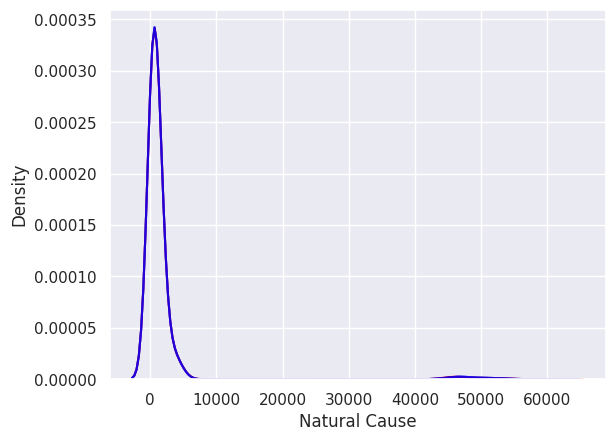

In [4]:
# Pool model.

ypred_df_pool = df_pool[['ypred.{}'.format(x) for x in range(1, n_pool+1)]].T.reset_index().drop(columns= "parameters")
fig, ax = plt.subplots()
fig.set_label("Pool model")
sns.kdeplot(df, x = "Natural Cause", ax = ax, color="red")
for i in range(1,10):
    sns.kdeplot(ypred_df_pool[i], ax = ax, color = 'blue', alpha = 0.2)


In [6]:
# Separate model

pp = PdfPages('./Plots/sep_predictive_check.pdf')
states = x_sep_df.columns
ypred_df_sep = df_sep[['ypred.{}.{}'.format(x,y) for x in range(1,groups_nof+1) for y in range(1,n_sep + 1)]].T

for j in range(0,54):
    fig, ax = plt.subplots()
    sns.kdeplot(df[df['Jurisdiction of Occurrence'] == states[j]], x = "Natural Cause", ax = ax, color="red")
    mask = ['ypred.{}.{}'.format(j+1,x) for x in range(1, n_sep + 1) ]
    for i in range(1,10):
        sns.kdeplot(ypred_df_sep.loc[mask, i], ax = ax, color = 'blue', alpha = 0.2)
    pp.savefig(fig)
    plt.close(fig)
pp.close()

## Predictive assessment (optional)

- Error
- Usefulness

## Sensitive anlysis
- Pool model: Since we expect that the natural cause should be higher than unnatural one. We could try 2 sensitive analysis prior for theta.

  - False informative: Beta(2,11)
  - Inofrmative: Beta(8,4)\

  

- Separate model

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0495vv9v/model_6cbk2ocl.stan', line 11, column 19: Argument
    11 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  15% (1200/8000)
Sampling:  24% (1900/8000)
Sampling:  49% (3900/8000)
Sampling:  68% (5400/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000107 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000108 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 sec

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  14% (1100/8000)
Sampling:  22% (1800/8000)
Sampling:  48% (3800/8000)
Sampling:  66% (5300/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 9.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.92 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000177 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.77 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.0001 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000178 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.78 seconds.
  Adjust your expectations accordingly!


<AxesSubplot: xlabel='theta', ylabel='Density'>

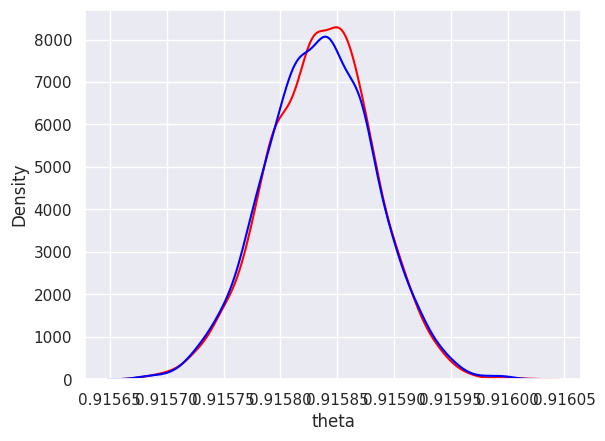

In [7]:
## Pool model

# Stan code:

f_inf_pool = """
data {
    int<lower=0> n;
    array[n] int x;
    array[n] int y;
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    theta ~ beta(2,11);
    y ~ binomial(x, theta);
}
"""
inf_pool = """
data {
    int<lower=0> n;
    array[n] int x;
    array[n] int y;
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    theta ~ beta(8,4);
    y ~ binomial(x, theta);
}
"""


post_f_inf_pool = stan.build(f_inf_pool, data = data_pool);
fit_f_inf_pool = post_f_inf_pool.sample(num_chains= 4, num_samples = 1000);
df_f_inf_pool = fit_f_inf_pool.to_frame()

post_inf_pool = stan.build(inf_pool, data = data_pool);
fit_inf_pool = post_inf_pool.sample(num_chains= 4, num_samples = 1000);
df_inf_pool = fit_inf_pool.to_frame()

# Plot theta from two models:

fig, axes = plt.subplots()
sns.kdeplot(df_f_inf_pool['theta'], ax = axes, color = 'red')
sns.kdeplot(df_inf_pool['theta'], ax = axes, color = 'blue')

In [1]:
# Separate model

# Stan code:

f_inf_sep= """
data {
    int<lower = 0> g; 
    int<lower=0> n;
    array[g,n] int x;
    array[g,n] int y;
}
parameters {
    array[g] real<lower=0, upper=1> theta;
}
model {
    for (i in 1:g) {
        theta[i] ~ beta(2,11);
        y[i] ~ binomial(x[i], theta[i]);
    }
}
"""
inf_sep= """
data {
    int<lower = 0> g; 
    int<lower=0> n;
    array[g,n] int x;
    array[g,n] int y;
}
parameters {
    array[g] real<lower=0, upper=1> theta;
}
model {
    for (i in 1:g) {
        theta[i] ~ beta(8,4);
        y[i] ~ binomial(x[i], theta[i]);
    }
}
"""

post_f_inf_sep = stan.build(f_inf_sep, data = data_sep);
fit_f_inf_sep = post_f_inf_sep.sample(num_chains= 4, num_samples = 1000);
df_f_inf_sep = fit_f_inf_sep.to_frame()

post_inf_sep = stan.build(inf_sep, data = data_sep);
fit_inf_sep = post_inf_sep.sample(num_chains= 4, num_samples = 1000);
df_inf_sep = fit_inf_sep.to_frame()

# Plot theta from two models:

fig, axes = plt.subplots()
sns.kdeplot(df_f_inf_sep['theta.54'], ax = axes, color = 'red')
sns.kdeplot(df_inf_sep['theta.54'], ax = axes, color = 'blue')

NameError: name 'stan' is not defined

## Model comparision and selection
- This could be done by loo or k-fold cross validation.

In [25]:
# LOO - Pool model.


compare_dict = {'separate': fit_sep, 'pool': fit_pool}
az.compare(compare_dict)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
separate,0,-73295.943847,150.156337,0.000000,0.711158,643.294182,0.000000,False,log
pool,1,-86155.166671,24.910609,12859.222824,0.288842,698.971189,881.571251,False,log
